In [1]:
from pathlib import Path
import pandas as pd
import json
import pyarrow as pa
import matplotlib

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import numpy as np

In [2]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns = None

In [3]:
#MOA
data_dir_moa = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/mechanismOfAction/')
moa_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_moa.glob('*.parquet')
)

#AE
data_dir = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/significantAdverseDrugReactions/')
ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

#TARGETS-PATHWAY
data_dir_targets = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/targets/')
targets_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_targets.glob('*.parquet')
)

In [4]:
#AE
data_dir_target = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/fda/adverseTargetReactions/')
target_ae_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_target.glob('*.parquet')
)

In [5]:
target_ae_full_df

reaction_reactionmeddrapt  uniq_report_ids_by_reaction   
0                     5q minus syndrome                           73  \
1                                abasia                         6090   
2                     abdominal abscess                         1443   
3                   abdominal adhesions                          774   
4                       abdominal bruit                           14   
...                                 ...                          ...   
30893                           yawning                          497   
30894                       yellow skin                         1057   
30895              zika virus infection                           24   
30896  zinc sulphate turbidity abnormal                            1   
30897                       zygomycosis                          103   

       uniq_report_ids_by_target   A         targetId      C     B        D   
0                          43633   2  ENSG00000100567  43631    71  4431203  \
1                          43633  48  ENSG00000100567  43585  6042  4425232   
2                          43633  25  ENSG00000100567  43608  1418  4429856   
3                          43633   1  ENSG00000100567  43632   773  4430501   
4                          43633   1  ENSG00000100567  43632    13  4431261   
...                          ...  ..              ...    ...   ...      ...   
30893                      29825   1  ENSG00000196262  29824   496  4444586   
30894                      29825   7  ENSG00000196262  29818  1050  4444032   
30895                      29825   1  ENSG00000196262  29824    23  4445059   
30896                      29825   1  ENSG00000196262  29824     0  4445082   
30897                      29825  14  ENSG00000196262  29811    89  4444993   

            aterm          cterm         acterm        llr meddraCode  
0       -7.194625 -202031.453144 -202039.425810   0.778042   10068532  
1     -232.473713 -201805.782707 -202039.425810   1.169390   10049460  
2     -101.390093 -201934.593656 -202039.425810   3.442060   10060921  
3       -6.651572 -202028.247932 -202039.425810   4.526306   10000050  
4       -2.639057 -202035.658866 -202039.425810   1.127887   10063943  
...           ...            ...            ...        ...        ...  
30893   -6.208590 -149442.586522 -149449.909983   1.114870   10048232  
30894  -35.120959 -149414.788881 -149449.909983   0.000143   10048245  
30895   -3.178054 -149445.739118 -149449.909983   0.992811   10078205  
30896    0.000000 -149445.892407 -149449.909983   4.017575   10048269  
30897  -27.939403 -149393.068007 -149449.909983  28.902572   10061418  

[2407546 rows x 13 columns]

In [6]:
#Indications
data_dir_indications = Path('C:/Users/ArulSeetharaman/Desktop/AdverseDrugReactions_SignalPrediction/Data/parquet/indication/')
indications_full_df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir_indications.glob('*.parquet')
)

### Mechanism of Action

In [7]:
select_moa_full_df = moa_full_df[['chemblIds','actionType','mechanismOfAction','targetName','targetType','targets']]
exploded_moa = select_moa_full_df.explode('chemblIds')
exploded_moa = exploded_moa.explode('targets')
exploded_moa = exploded_moa.apply(lambda x : x.str.strip())

### Flatten pathway from Target dataframe

In [8]:
target_pathway = targets_full_df[targets_full_df.pathways.notnull()]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[['id','approvedName', 'pathways']]

target_pathway = target_pathway[target_pathway.id.notnull()]

exploded_target_pathway = target_pathway.explode('pathways')

exploded_target_pathway['pathways'] =  exploded_target_pathway['pathways'].astype("string")

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.strip('{}')

exploded_target_pathway['pathways'] = exploded_target_pathway.pathways.str.replace("'",'')

pathways= exploded_target_pathway['pathways']

### Split pathway column into three columns - 'pathwayId', 'pathway','topLevelTerm'

In [9]:
pathways =  exploded_target_pathway.pathways.astype(str).str.split(",",expand=True)

pathways.columns = ["pathwayId", "pathway","topLevelTerm","empty1","empty2","empty3"]

pathways.drop(pathways.columns[[3,4,5]],axis=1,inplace=True)

### Lamda function to strip unwanted characters

In [10]:
pathways = pathways.apply(lambda x : x.str.split('\:').str[-1].str.strip())

### Merge back pathway columns - 'pathwayId', 'pathway' and 'topLevelTerm' to 'exploded_target_pathways' dataframe

In [11]:
wide_taget_pathway = pd.concat([exploded_target_pathway,pathways],axis=1)

wide_taget_pathway = wide_taget_pathway.drop('pathways',axis=1)

wide_taget_pathway = wide_taget_pathway.apply(lambda x : x.str.strip())

### Merge drug, target, pathway and mechanism of action information from  'exploded_moa' with 'wide_target_pathway'

In [12]:
drug_targets_moa_pathway = pd.merge(exploded_moa,wide_taget_pathway, left_on='targets',right_on = 'id',how='left')

drug_targets_moa_pathway = drug_targets_moa_pathway.drop('id', axis = 1)

clean_drug_targets_moa_pathway = drug_targets_moa_pathway[drug_targets_moa_pathway.pathway.notnull()]

clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway[clean_drug_targets_moa_pathway.targets.notnull()]

In [13]:
clean_drug_targets_moa_pathway = clean_drug_targets_moa_pathway.drop_duplicates(subset= ['chemblIds'	,'actionType'	,'mechanismOfAction'	,'targetName',	'targetType',	'targets',	'approvedName',	'pathwayId',	'pathway',	'topLevelTerm'])

### Merge Indications

In [14]:
indications_full_df = indications_full_df[indications_full_df.id.notnull()]

exploded_indications = indications_full_df.explode('approvedIndications')

exploded_indications.drop(['indications','indicationCount'], axis =1,inplace=True)

exploded_indications = exploded_indications[exploded_indications.approvedIndications.notna()]

exploded_indications = exploded_indications.drop_duplicates(subset = ['id','approvedIndications'])

### New unified dataset with Indications , Action type, Target; removed Mechanism of action

In [15]:
drug_targets_moa_pathway_indications = pd.merge(clean_drug_targets_moa_pathway,exploded_indications, left_on='chemblIds',right_on = 'id',how='left')

In [16]:
drug_targets_moa_pathway_indications.drop(['id','targetName','targetType', 'pathwayId','pathway','mechanismOfAction','approvedName'],axis=1,inplace=True)

clean_drug_targets_moa_pathway_indications = drug_targets_moa_pathway_indications.drop_duplicates(subset=['chemblIds','actionType','targets','topLevelTerm','approvedIndications'])

In [17]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications.rename(columns = {'topLevelTerm': 'pathwayCategory'})

### Omit drugs without indications; 2831 drugs do not have approved indications

In [18]:
clean_drug_targets_moa_pathway_indications = clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.approvedIndications.isna()]

### ADVERSE EVENTS dataset

#### Remove duplicates

In [19]:
moa_with_drug_action_type = exploded_moa [['chemblIds','actionType']]

moa_with_drug_action_type = moa_with_drug_action_type.drop_duplicates(subset=['chemblIds'])

ae_action_type =  pd.merge(ae_full_df,moa_with_drug_action_type, left_on = 'chembl_id', right_on = 'chemblIds', how = 'left')

clean_ae_action_type = ae_action_type[ae_action_type.actionType.notna()]

summary_ae_drug_action_type = clean_ae_action_type[['chembl_id','actionType','count','event']].groupby(['actionType']).agg(adverse_event_count= ('event','count'),sum_reported_adverse_events=('count','sum'))



#### Group AE

In [20]:
adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

In [21]:
summary_action_type = clean_drug_targets_moa_pathway.groupby('actionType').agg(moa_count= ('mechanismOfAction','nunique'),pathway_count= ('pathway','nunique'))

#summary_drug_targets = clean_drug_targets_moa_pathway.groupby('targets').agg(Frequency_distribution_targets= ('chemblIds','count'))

#summary_drug_pathways = clean_drug_targets_moa_pathway.groupby('pathway').agg(Frequency_distribution_pathway= ('chemblIds','count'))

#summary_cae_moa = ae_moa.groupby('topLevelTerm').agg(adverse_event_count= ('event','count'))

### Select drugs with Adverse events

In [22]:
known_drugs_with_ae =  clean_drug_targets_moa_pathway_indications[clean_drug_targets_moa_pathway_indications.chemblIds.isin(adverse_events_grouped['chembl_id'])]

drugs_without_ae =  clean_drug_targets_moa_pathway_indications[~clean_drug_targets_moa_pathway_indications.chemblIds.isin(adverse_events_grouped['chembl_id'])]

## Data Split

### Split Train, test, cv data into 60,20,20 ratio

In [23]:
train, validation, test = \
              np.split(known_drugs_with_ae.sample(frac=1, random_state=42), 
                       [int(.6*len(known_drugs_with_ae)), int(.8*len(known_drugs_with_ae))])  #  train =0.6, val = 1-0.8,  test = diff(0.6-0.8)

### Cross Validation

In [24]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

# prepare cross validation
np.random.seed(100)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
#Split train into K=5 folds
for i, (_, v_ind) in enumerate(kf.split(validation)):
    validation.loc[validation.index[v_ind], 'kfold'] = f"fold{i+1}"

In [25]:
fold_1 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_2 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_3 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_4 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']
fold_5 = validation.loc[validation['kfold']=='fold1',validation.columns!='kfold']

### Encode categorical columns

In [26]:
one_hot_encoded = pd.get_dummies(train, columns= ["actionType","targets","pathwayCategory","approvedIndications"])

one_hot_encoded = one_hot_encoded.groupby('chemblIds').sum().clip(upper=1)

In [31]:
one_hot_encoded

actionType_ACTIVATOR  actionType_AGONIST  actionType_ANTAGONIST   
chemblIds                                                                       
CHEMBL1000                       0                   0                      1  \
CHEMBL100116                     0                   0                      0   
CHEMBL1002                       0                   1                      0   
CHEMBL1008                       0                   0                      0   
CHEMBL1009                       0                   1                      0   
...                            ...                 ...                    ...   
CHEMBL995                        0                   0                      1   
CHEMBL9967                       0                   0                      1   
CHEMBL997                        0                   0                      0   
CHEMBL998                        0                   0                      1   
CHEMBL99946                      0                   0                      0   

              actionType_ANTISENSE INHIBITOR  actionType_BINDING AGENT   
chemblIds                                                                
CHEMBL1000                                 0                         0  \
CHEMBL100116                               0                         0   
CHEMBL1002                                 0                         0   
CHEMBL1008                                 0                         0   
CHEMBL1009                                 0                         0   
...                                      ...                       ...   
CHEMBL995                                  0                         0   
CHEMBL9967                                 0                         0   
CHEMBL997                                  0                         0   
CHEMBL998                                  0                         0   
CHEMBL99946                                0                         0   

              actionType_BLOCKER  actionType_CROSS-LINKING AGENT   
chemblIds                                                          
CHEMBL1000                     0                               0  \
CHEMBL100116                   0                               0   
CHEMBL1002                     0                               0   
CHEMBL1008                     1                               0   
CHEMBL1009                     0                               0   
...                          ...                             ...   
CHEMBL995                      0                               0   
CHEMBL9967                     0                               0   
CHEMBL997                      0                               0   
CHEMBL998                      0                               0   
CHEMBL99946                    0                               0   

              actionType_HYDROLYTIC ENZYME  actionType_INHIBITOR   
chemblIds                                                          
CHEMBL1000                               0                     0  \
CHEMBL100116                             0                     0   
CHEMBL1002                               0                     0   
CHEMBL1008                               0                     0   
CHEMBL1009                               0                     0   
...                                    ...                   ...   
CHEMBL995                                0                     0   
CHEMBL9967                               0                     0   
CHEMBL997                                0                     1   
CHEMBL998                                0                     0   
CHEMBL99946                              0                     1   

              actionType_INVERSE AGONIST  actionType_MODULATOR   
chemblIds                                                        
CHEMBL1000                             0                     0  \
CHEMBL100116                 

### Convert to numpy array

In [32]:
nd_array = one_hot_encoded.to_numpy()

In [33]:
import threading
threading.active_count()

7

# Similarity

### Calculate Similarity -Jaccard

In [35]:
jac_sim = 1 - pairwise_distances(nd_array, metric='jaccard',n_jobs =-2)

jac_sim_df = pd.DataFrame(jac_sim, index= one_hot_encoded.index, columns=one_hot_encoded.index)

c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Transform to Longform

In [36]:
# move to long form
long_form = jac_sim_df.unstack()
# rename columns and turn into a dataframe
long_form.index.rename(['Drug_1', 'Drug_2'], inplace=True)
long_form = long_form.to_frame('jaccard_similarity').reset_index()

long_form = long_form[
        (long_form['Drug_1'] != long_form['Drug_2'])
].sort_values('jaccard_similarity',ascending = True)

long_form['jaccard_similarity'] = round(long_form['jaccard_similarity'],2)

## Score Distribution

<Axes: >

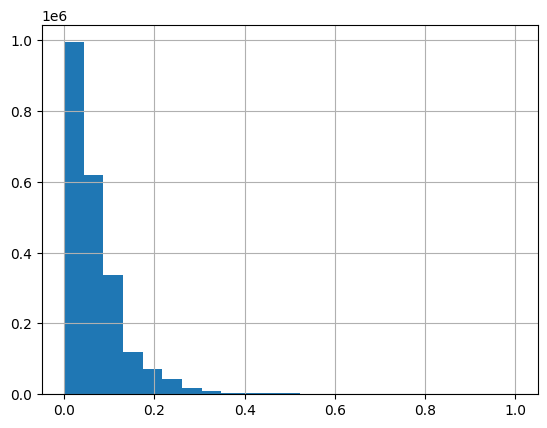

In [37]:
long_form.jaccard_similarity.hist(bins='sturges')


In [150]:
#score_distribution

### Drop multiple comparisons (duplicate drug pairs)

In [38]:
similar_drugs = long_form.drop_duplicates(subset=['Drug_1','Drug_2'])

In [63]:
long_form

Drug_1         Drug_2  jaccard_similarity
1           CHEMBL1000   CHEMBL100116                 0.0
1129494  CHEMBL2095212     CHEMBL1034                 0.0
1129499  CHEMBL2095212     CHEMBL1054                 0.0
1129500  CHEMBL2095212     CHEMBL1055                 0.0
1129501  CHEMBL2095212     CHEMBL1059                 0.0
...                ...            ...                 ...
1272055  CHEMBL2138684     CHEMBL1278                 1.0
820749      CHEMBL1519  CHEMBL3039598                 1.0
2170611      CHEMBL904      CHEMBL827                 1.0
2061511      CHEMBL750     CHEMBL1068                 1.0
915397      CHEMBL1678      CHEMBL659                 1.0

[2236520 rows x 3 columns]

### Group drugs by adverse events

In [39]:
adverse_events_grouped = ae_full_df.groupby('chembl_id')['event'].apply(list).reset_index(name='adverse_events')

### KG results

In [126]:
path_102 = Path('C:/Users/ArulSeetharaman/Desktop/ADR_DrugSafety/Sai/drug similarity102export.csv')
path_10 = Path('C:/Users/ArulSeetharaman/Desktop/ADR_DrugSafety/Sai/drug similarity10export.csv')
df_102 = pd.read_csv(path_102)
df_10 = pd.read_csv(path_10)
df_102 = df_102[
        (df_102['Drug_1'] != df_102['Drug_2'])
].sort_values('jaccard_similarity',ascending = True)
df_102['jaccard_similarity'] = round(df_102['jaccard_similarity'],2)
drug_pairs = df_102.drop_duplicates(subset=['Drug_1','Drug_1','jaccard_similarity'])

### Merge similar drugs with Adverse Events

In [41]:
similar_drugs_ae = pd.merge(similar_drugs,adverse_events_grouped, left_on= 'Drug_1'  , right_on = 'chembl_id'  , how ='left')
similar_drugs_ae = pd.merge(similar_drugs_ae,adverse_events_grouped, left_on= 'Drug_2'  , right_on = 'chembl_id'  , how ='left')

similar_drugs_ae = similar_drugs_ae[(similar_drugs_ae.chembl_id_x.notna()) | (similar_drugs_ae.chembl_id_y.notna())]

isna = similar_drugs_ae['adverse_events_x'].isna()
similar_drugs_ae.loc[isna,'adverse_events_x'] = pd.Series([[]] * isna.sum()).values

isnay = similar_drugs_ae['adverse_events_y'].isna()
similar_drugs_ae.loc[isnay,'adverse_events_y'] = pd.Series([[]] * isnay.sum()).values

### Find common AEs

In [42]:
similar_drugs_ae['common_adverse_events'] = [list(set(a).intersection(set(b))) for a, b in zip(similar_drugs_ae.adverse_events_x, similar_drugs_ae.adverse_events_y)]

In [44]:
#similar_drugs_ae

### Replace blank AEs with left out pair AE's value

In [118]:
#similar_drugs_ae.loc[similar_drugs_ae.adverse_events_x.str.len() == 0 , 'common_adverse_events'] = similar_drugs_ae['adverse_events_y']
#similar_drugs_ae.loc[similar_drugs_ae.adverse_events_y.str.len() == 0 , 'common_adverse_events'] = similar_drugs_ae['adverse_events_x']

### Remove records with no common AEs

In [119]:
#similar_drugs_ae = similar_drugs_ae[similar_drugs_ae.common_adverse_events.str.len() > 0]

In [45]:
similar_drugs_ae['common_adverse_events'] = similar_drugs_ae.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [53]:
similar_drugs_ae_grouped = similar_drugs_ae.groupby('Drug_1')[['Drug_2','common_adverse_events','jaccard_similarity']].agg(lambda x: list(x)).reset_index()

In [54]:
similar_drugs_ae_grouped['common_adverse_events'] = similar_drugs_ae_grouped.common_adverse_events.astype("string").str.replace('[', '').str.replace(']', '').str.replace('"', '')

In [57]:
#similar_drugs_ae_grouped.jaccard_similarity.mean()

### Remove Duplicate AEs

In [132]:
similar_drugs_ae_grouped['unique_ae'] = similar_drugs_ae_grouped['common_adverse_events'].apply(lambda x: set(x.split(',')))

In [133]:
similar_drugs_ae_grouped = similar_drugs_ae_grouped.drop('common_adverse_events',axis=1)

In [64]:
#similar_drugs_ae_grouped

## validation 

In [75]:
val_train_set = pd.concat([train,fold_1])

In [77]:
val_one_hot_encoded

actionType_ACTIVATOR  actionType_AGONIST  actionType_ANTAGONIST   
chemblIds                                                                       
CHEMBL1000                       0                   0                      1  \
CHEMBL100116                     0                   0                      0   
CHEMBL1002                       0                   1                      0   
CHEMBL1008                       0                   0                      0   
CHEMBL1009                       0                   1                      0   
...                            ...                 ...                    ...   
CHEMBL995                        0                   0                      1   
CHEMBL9967                       0                   0                      1   
CHEMBL997                        0                   0                      0   
CHEMBL998                        0                   0                      1   
CHEMBL99946                      0                   0                      0   

              actionType_ANTISENSE INHIBITOR  actionType_BINDING AGENT   
chemblIds                                                                
CHEMBL1000                                 0                         0  \
CHEMBL100116                               0                         0   
CHEMBL1002                                 0                         0   
CHEMBL1008                                 0                         0   
CHEMBL1009                                 0                         0   
...                                      ...                       ...   
CHEMBL995                                  0                         0   
CHEMBL9967                                 0                         0   
CHEMBL997                                  0                         0   
CHEMBL998                                  0                         0   
CHEMBL99946                                0                         0   

              actionType_BLOCKER  actionType_CROSS-LINKING AGENT   
chemblIds                                                          
CHEMBL1000                     0                               0  \
CHEMBL100116                   0                               0   
CHEMBL1002                     0                               0   
CHEMBL1008                     1                               0   
CHEMBL1009                     0                               0   
...                          ...                             ...   
CHEMBL995                      0                               0   
CHEMBL9967                     0                               0   
CHEMBL997                      0                               0   
CHEMBL998                      0                               0   
CHEMBL99946                    0                               0   

              actionType_HYDROLYTIC ENZYME  actionType_INHIBITOR   
chemblIds                                                          
CHEMBL1000                               0                     0  \
CHEMBL100116                             0                     0   
CHEMBL1002                               0                     0   
CHEMBL1008                               0                     0   
CHEMBL1009                               0                     0   
...                                    ...                   ...   
CHEMBL995                                0                     0   
CHEMBL9967                               0                     0   
CHEMBL997                                0                     1   
CHEMBL998                                0                     0   
CHEMBL99946                              0                     1   

              actionType_INVERSE AGONIST  actionType_MODULATOR   
chemblIds                                                        
CHEMBL1000                             0                     0  \
CHEMBL100116                 

### Calculate similarity

In [76]:
val_one_hot_encoded = pd.get_dummies(val_train_set, columns= ["actionType","targets","pathwayCategory","approvedIndications"])

val_one_hot_encoded = val_one_hot_encoded.groupby('chemblIds').sum().clip(upper=1)

val_nd_array = val_one_hot_encoded.to_numpy()

val_jac_sim = 1 - pairwise_distances(val_nd_array, metric='jaccard',n_jobs =-2)

val_jac_sim_df = pd.DataFrame(val_jac_sim, index= val_one_hot_encoded.index, columns=val_one_hot_encoded.index)


c:\Users\ArulSeetharaman\Miniconda3\lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Find drugs similar to validation set

In [78]:
# move to long form
val_long_form = val_jac_sim_df.unstack()
# rename columns and turn into a dataframe
val_long_form.index.rename(['Drug_1', 'Drug_2'], inplace=True)
val_long_form = val_long_form.to_frame('jaccard_similarity').reset_index()

val_long_form = val_long_form[
        (val_long_form['Drug_1'] != val_long_form['Drug_2'])
].sort_values('jaccard_similarity',ascending = True)

val_long_form['jaccard_similarity'] = round(val_long_form['jaccard_similarity'],2)

In [79]:
val_long_form

Drug_1         Drug_2  jaccard_similarity
1           CHEMBL1000   CHEMBL100116                 0.0
1138646    CHEMBL20883  CHEMBL2219418                 0.0
1138647    CHEMBL20883  CHEMBL2219425                 0.0
1138654    CHEMBL20883  CHEMBL2311030                 0.0
1138656    CHEMBL20883  CHEMBL2336071                 0.0
...                ...            ...                 ...
975362      CHEMBL1722      CHEMBL827                 1.0
626339   CHEMBL1213351  CHEMBL3989826                 1.0
626331   CHEMBL1213351  CHEMBL3989716                 1.0
1125062  CHEMBL2048484  CHEMBL2107830                 1.0
635685      CHEMBL1224      CHEMBL829                 1.0

[2257506 rows x 3 columns]

### Filter validation drugs

In [80]:
val_drug_pairs = val_long_form[val_long_form.Drug_1.isin(fold_1.chemblIds)]

In [81]:
val_drug_pairs

Drug_1         Drug_2  jaccard_similarity
1139274  CHEMBL2095208     CHEMBL1000                 0.0
1139275  CHEMBL2095208   CHEMBL100116                 0.0
1139276  CHEMBL2095208     CHEMBL1002                 0.0
1139278  CHEMBL2095208     CHEMBL1009                 0.0
1139280  CHEMBL2095208     CHEMBL1014                 0.0
...                ...            ...                 ...
202724   CHEMBL1200449      CHEMBL632                 1.0
586390   CHEMBL1201765  CHEMBL1200935                 1.0
445169   CHEMBL1201222  CHEMBL1201178                 1.0
2081964      CHEMBL750  CHEMBL1201336                 1.0
975362      CHEMBL1722      CHEMBL827                 1.0

[892188 rows x 3 columns]

### Validation Common AEs

In [172]:
train_drug_ae_grouped = similar_drugs_ae_grouped[~similar_drugs_ae_grouped.Drug_1.isin(validation.index)] # removing val drugs

In [174]:
val_matched_drugs =  train_drug_ae_grouped[train_drug_ae_grouped.Drug_1.isin(val_drug_pairs.Drug_2)]

In [225]:
predicted_true_comparison_4 = pd.merge(val_matched_drugs,adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')
predicted_true_comparison_4['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_4['unique_ae']]
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.astype("string")
predicted_true_comparison_4['unique_ae_array'] = predicted_true_comparison_4.unique_ae_array.str.replace('"',"").str.replace("'',","").str.replace("''",'')
predicted_true_comparison_4['adverse_events'] = predicted_true_comparison_4.adverse_events.astype("string")
predicted_true_comparison_4['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_4.adverse_events.str.split(","), predicted_true_comparison_4.unique_ae_array.str.split(","))]
predicted_true_comparison_4['actual_count'] = predicted_true_comparison_4.adverse_events.str.split(",").str.len()
predicted_true_comparison_4['predicted_count'] = predicted_true_comparison_4.common_predicted_actual.str.len()
predicted_true_comparison_4 = predicted_true_comparison_4.drop('unique_ae', axis=1)
predicted_true_comparison_4['accuracy'] = round((predicted_true_comparison_4['predicted_count'] /predicted_true_comparison_4['actual_count']),2) 

In [227]:
predicted_true_comparison_4.to_csv("kg_validation_predictionv1.csv")    


In [165]:
predicted_true_comparison_5 = pd.merge(similar_drugs_ae_grouped[similar_drugs_ae_grouped.Drug_1.isin(fold_5.index)],adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')
predicted_true_comparison_5['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_5['unique_ae']]
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_5['unique_ae_array'] = predicted_true_comparison_5.unique_ae_array.astype("string")
predicted_true_comparison_5['adverse_events'] = predicted_true_comparison_5.adverse_events.astype("string")
predicted_true_comparison_5['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_5.adverse_events.str.split(","), predicted_true_comparison_5.unique_ae_array.str.split(","))]
predicted_true_comparison_5['actual_count'] = predicted_true_comparison_5.adverse_events.str.split(",").str.len()
predicted_true_comparison_5['predicted_count'] = predicted_true_comparison_5.common_predicted_actual.astype("string").str.split(",").str.len()
predicted_true_comparison_5 = predicted_true_comparison_5.drop('unique_ae', axis=1)
predicted_true_comparison_5['accuracy'] = round((predicted_true_comparison_5['predicted_count'] /predicted_true_comparison_5['actual_count']),2) 

In [182]:
predicted_true_comparison_6 = pd.merge(similar_drugs_ae_grouped[similar_drugs_ae_grouped.Drug_1.isin(test_data.index)],adverse_events_grouped, left_on= 'Drug_1', right_on= 'chembl_id', how= 'inner')


In [183]:
predicted_true_comparison_6

Empty DataFrame
Columns: [Drug_1, Drug_2, unique_ae, chembl_id, adverse_events]
Index: []

In [ ]:
predicted_true_comparison_6['unique_ae_array'] = [','.join(map(str, l)) for l in predicted_true_comparison_6['unique_ae']]
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6.unique_ae_array.str.replace("'","").str.split(",")
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6['unique_ae_array'].apply(lambda x: list(map(str.strip, x)))
predicted_true_comparison_6['unique_ae_array'] = predicted_true_comparison_6.unique_ae_array.astype("string")
predicted_true_comparison_6['adverse_events'] = predicted_true_comparison_6.adverse_events.astype("string")
predicted_true_comparison_6['common_predicted_actual'] = [list(set(a).intersection(set(b))) for a, b in zip(predicted_true_comparison_6.adverse_events.str.split(","), predicted_true_comparison_6.unique_ae_array.str.split(","))]
predicted_true_comparison_6['actual_count'] = predicted_true_comparison_6.adverse_events.str.split(",").str.len()
predicted_true_comparison_6['predicted_count'] = predicted_true_comparison_6.common_predicted_actual.astype("string").str.split(",").str.len()
predicted_true_comparison_6 = predicted_true_comparison_6.drop('unique_ae', axis=1)
predicted_true_comparison_6['accuracy'] = round((predicted_true_comparison_6['predicted_count'] /predicted_true_comparison_6['actual_count']),2) 

## Prediction Results and Accuracy

In [167]:
predicted_true_comparison_1.accuracy.mean()


0.5628846153846154

In [172]:
predicted_true_comparison_2.accuracy.mean()


0.5371028037383176

In [173]:
predicted_true_comparison_3.accuracy.mean()


0.5529473684210525

In [228]:
predicted_true_comparison_4.accuracy.mean()


0.020424

In [175]:
predicted_true_comparison_5.accuracy.mean()

0.5496428571428572

In [181]:
predicted_true_comparison_6.accuracy.mean()

AttributeError: 'DataFrame' object has no attribute 'accuracy'

In [176]:
train_data

actionType_ACTIVATOR  actionType_AGONIST   
chemblIds                                                 
CHEMBL1201284                     0                   0  \
CHEMBL1201286                     0                   0   
CHEMBL1201287                     0                   0   
CHEMBL1201288                     0                   0   
CHEMBL1201293                     0                   0   
...                             ...                 ...   
CHEMBL995                         0                   0   
CHEMBL9967                        0                   0   
CHEMBL997                         0                   0   
CHEMBL998                         0                   0   
CHEMBL99946                       0                   0   

               actionType_ANTAGONIST  actionType_ANTISENSE INHIBITOR   
chemblIds                                                              
CHEMBL1201284                      0                               0  \
CHEMBL1201286                      1                               0   
CHEMBL1201287                      1                               0   
CHEMBL1201288                      1                               0   
CHEMBL1201293                      1                               0   
...                              ...                             ...   
CHEMBL995                          1                               0   
CHEMBL9967                         1                               0   
CHEMBL997                          0                               0   
CHEMBL998                          1                               0   
CHEMBL99946                        0                               0   

               actionType_BINDING AGENT  actionType_BLOCKER   
chemblIds                                                     
CHEMBL1201284                         0                   0  \
CHEMBL1201286                         0                   0   
CHEMBL1201287                         0                   0   
CHEMBL1201288                         0                   0   
CHEMBL1201293                         0                   0   
...                                 ...                 ...   
CHEMBL995                             0                   0   
CHEMBL9967                            0                   0   
CHEMBL997                             0                   0   
CHEMBL998                             0                   0   
CHEMBL99946                           0                   0   

               actionType_CROSS-LINKING AGENT  actionType_HYDROLYTIC ENZYME   
chemblIds                                                                     
CHEMBL1201284                               0                             0  \
CHEMBL1201286                               0                             0   
CHEMBL1201287                               0                             0   
CHEMBL1201288                               0                             0   
CHEMBL1201293                               0                             0   
...                                       ...                           ...   
CHEMBL995                                   0                             0   
CHEMBL9967                                  0                             0   
CHEMBL997                                   0                             0   
CHEMBL998                                   0                             0   
CHEMBL99946                                 0                             0   

               actionType_INHIBITOR  actionType_INVERSE AGONIST   
chemblIds                                                         
CHEMBL1201284                     0                           0  \
CHEMBL1201286                     0                           0   
CHEMBL1201287                     0                           0   
CHEMBL1201288                     0                           0   
CHEMBL1201293                     0                         

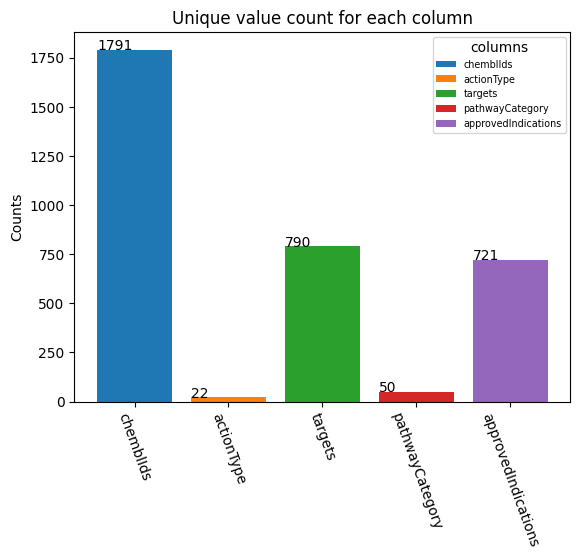

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
counts = clean_drug_targets_moa_pathway_indications.nunique().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(columns, counts, label=columns, color=colors)
xlocs, xlabs = plt.xticks()

ax.set_ylabel('Counts')
ax.set_title('Unique value count for each column')
ax.legend(title='columns',fontsize ='x-small')
ax.tick_params('x', labelrotation=290)

for i, v in enumerate(counts):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

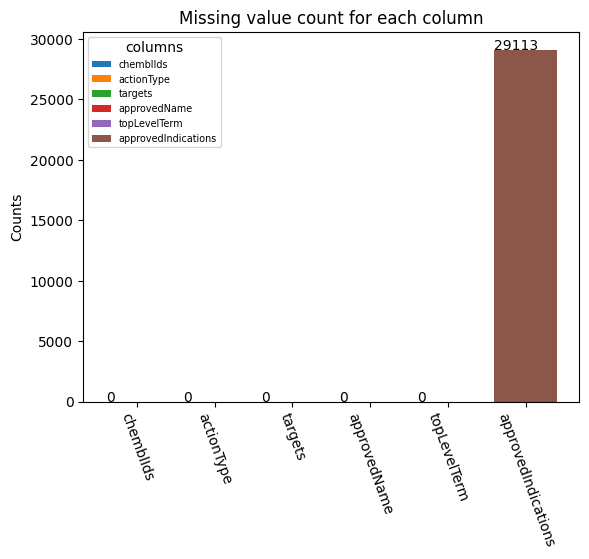

In [314]:
fig_missing, ax_missing = plt.subplots()

columns = clean_drug_targets_moa_pathway_indications.columns.tolist()
missing_count = clean_drug_targets_moa_pathway_indications.isna().sum().tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#0000EE','#FFEBCD','#E3CF57']
#bar_labels = ['red', 'blue', '_red', 'orange']
#bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax_missing.bar(columns, missing_count, label=columns, color=colors)
xlocs, xlabs = plt.xticks()
ax_missing.set_ylabel('Counts')
ax_missing.set_title('Missing value count for each column')
ax_missing.legend(title='columns',fontsize ='x-small')
ax_missing.tick_params('x', labelrotation=290)

for i, v in enumerate(missing_count):
    plt.text(xlocs[i] - 0.40, v + 0.01, str(v))

plt.show()

In [65]:
import scipy
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
from scipy.stats import chi2_contingency
import numpy as np

In [63]:
ae_moa = pd.merge(ae_full_df,clean_drug_targets_moa_pathway_indications, left_on = 'chembl_id', right_on = 'chemblIds', how = 'inner')

ae_moa = ae_moa[['chembl_id','event','actionType','targets','pathwayCategory','approvedIndications']]

In [66]:
data_encoded = pd.DataFrame() 
for i in ae_moa.columns:
    data_encoded[i]=label.fit_transform(ae_moa[i])

In [67]:
def cramers_rule(var1,var2) :
    crosstab=pd.crosstab(index=var1, columns=var2)
    stat = scipy.stats.contingency.association(crosstab)
    return stat

rows=[]  
for var1 in ae_moa.columns.tolist(): 
    col=[]
    for var2 in ae_moa.columns.tolist(): 
        cramers =cramers_rule(ae_moa[var1], ae_moa[var2])
        col.append(round(cramers,2))
    rows.append(col)
cramers_results = np.array(rows) 
craemrs_correlation = pd.DataFrame(cramers_results,columns = data_encoded.columns, index=data_encoded.columns)

In [68]:
craemrs_correlation.style.background_gradient(cmap='YlGnBu')